In [1]:
import numpy as np
from numba import jit
from scipy.special import comb
import scipy.optimize as optimize
from matplotlib import pyplot as plt
import numpy.polynomial.polynomial as nppp
%matplotlib inline

# BDT Model - Binomial Tree


In [2]:
#return interst rate of each node
@jit
def generateBTR(r0,drift,sigma,n,year): 
    n_level = n * year
    BT = np.zeros((n_level, n_level))
    BT[0][0] = r0
    deltaT=1/n
    for i in range(1, n_level):
        BT[:, i] = BT[:, i - 1] * np.exp(drift*deltaT+sigma*np.sqrt(deltaT))
        BT[i][i] = BT[i - 1][i - 1] * np.exp(drift*deltaT-sigma*np.sqrt(deltaT))
    return BT

#return discount rate between each deltaT
@jit
def generateBT(r0,drift,sigma,n,year): 
    BTR = generateBTR(r0,drift,sigma,n,year)
    deltaT=1/n
    return np.exp(-BTR*deltaT)

@jit
def discountedValue(BT,n):
    result = BT[:n, n - 1]
    for i in np.arange(n-1,0,-1):
        result = 0.5 * (result[:-1] + result[1:]) * BT[:i, i - 1]
    return result[0]

'''
r0=current continous conpouding short rate
drift,sigma=parameters in model
n=numer of steps in year
year=matirity
cFrq=how many times of coupon payment per year
c=coupon rate
principle=face value
'''
@jit
def vanillaBond(r0,drift,sigma,n,year,cFrq,c,principle):
    BT=generateBT(r0,drift,sigma,n,year)
    price=principle*discountedValue(BT,year*n) 
    for t in np.array(range(1,cFrq*year+1))/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BT,int(t*n))  
    return price

@jit
def callableBond(r0,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime):
    
    BTRt=generateBTR(r0,drift,sigma,n,callTime)
    BTt=generateBT(r0,drift,sigma,n,callTime)
    
    newR=BTRt[:, n*callTime - 1].squeeze()
    len_newR = len(newR)
    
    price=0
    count=0
    for r in newR:
        p1=min(vanillaBond(r,drift,sigma,n,year-callTime,cFrq,c,principle),callPirce)
        price+=p1*discountedValue(BTt,callTime*n)*comb(len_newR-1, count)/(2**(len(newR)-1))
        count+=1
        
    for t in np.arange(1,cFrq*callTime+1)/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BTt,int(t*n))  
    return price

def ytm(price,c,principle,cFrq,year):
    
    freq = float(cFrq)
    periods = year*freq
    coupon = c*principle/cFrq
    dt = [(i+1)/freq for i in range(int(periods))]
    ytm_func = lambda y: sum([coupon/(1+y/freq)**(freq*t) for t in dt]) + principle/(1+y/freq)**(freq*year) - price
    
    return optimize.newton(ytm_func, 0.03)

## Callable Bond Price using BDT model

In [3]:
drift=0.01
sigma=0.4
n=6
year=30
cFrq=2
c=0.03
principle=100
callPirce=101
callTime=3

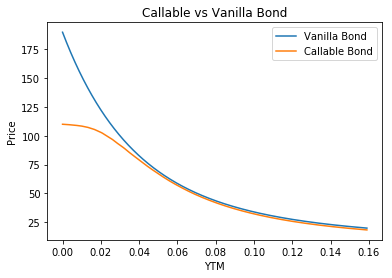

In [7]:
y=[]
price=[]
priceC=[]
for r in np.arange(0, 0.2, 0.0001):
    p=vanillaBond(r,drift,sigma,n,year,cFrq,c,principle)
    y.append(ytm(p,c,principle,cFrq,year))
    price.append(p)
    priceC.append(callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime))
plt.figure(figsize=(6,4))    
plt.plot(y,price,label='Vanilla Bond') 
plt.plot(y,priceC,label='Callable Bond')
plt.title('Callable vs Vanilla Bond')
plt.xlabel('YTM')
plt.ylabel('Price')
plt.legend()
plt.show()

C:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


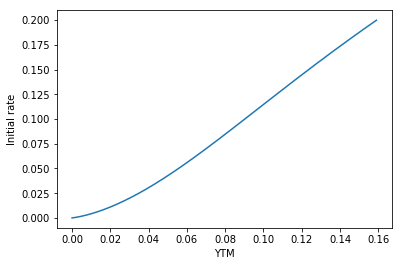

In [8]:
rf = np.arange(0, 0.2, 0.0001)
plt.figure(figsize=(6,4))    
plt.plot(y,rf) 
#plt.plot(y,priceC,label='Callable Bond')
plt.xlabel('YTM')
plt.ylabel('Initial rate')
plt.legend()
plt.show()

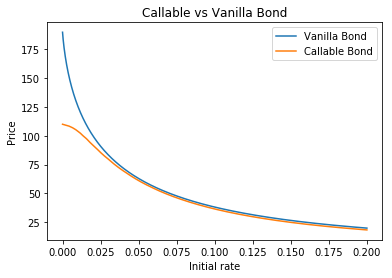

In [10]:
plt.figure(figsize=(6,4))    
plt.plot(rf,price,label='Vanilla Bond') 
plt.plot(rf,priceC,label='Callable Bond')
plt.title('Callable vs Vanilla Bond')
plt.xlabel('Initial rate')
plt.ylabel('Price')
plt.legend()
plt.show()

In [69]:
price = np.array(price)
priceC = np.array(priceC)
y = np.array(y)

## Call option price

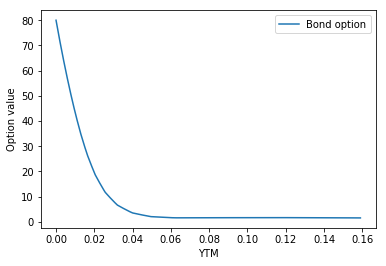

In [70]:
option_value = price - priceC
plt.figure(figsize=(6,4))    
plt.plot(y,option_value,label='Bond option')
plt.xlabel('YTM')
plt.ylabel('Option value')
plt.legend()
plt.show()

## savgol_filter

Fit the callable bond price curve to make it smooth

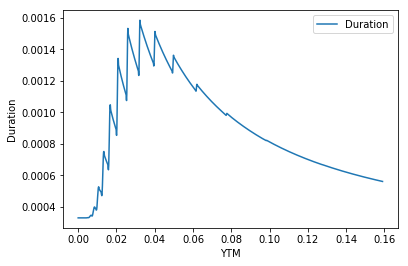

In [71]:
from scipy.signal import savgol_filter
smooth_p= savgol_filter(priceC, 11, 3, deriv=1)
duration = -smooth_p / priceC

plt.figure(figsize=(6,4))    
plt.plot(y,duration,label='Duration')
plt.xlabel('YTM')
plt.ylabel('Duration')
plt.legend()
plt.show()

Due to indifferentiability of duration curve, the convexity curve is severely affected by the extreme values, as demostrated below

### Convexity - 1st approach by second derivative 

We apply the convexity spproximation formula, which is the second derivative of price.<br>
$$Convexity = \frac{P_+ + P_- - 2P_0}{2 P_0 (\Delta y)^2}$$

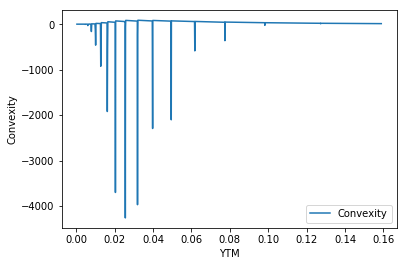

In [72]:
delt = 1
base= 1

convexity = (priceC[:(-2*delt)] + priceC[(base+delt):] - 2*priceC[base:(-delt)])/\
(2*priceC[base:-(delt)]*np.square(y[(base+delt):] - y[:-(base+delt)])) 

plt.figure(figsize=(6,4))    
plt.plot(y[base:-(delt)],convexity,label='Convexity')
plt.xlabel('YTM')
plt.ylabel('Convexity')
plt.legend()
plt.show()

### Convexity - 2nd approach by smoothing the price 

We apply **<b>moving average technique</b>** to smooth the callable bond price. This technique preserve the trending pattern in the original price curve

In [73]:
def smooth_ave(d, period = 3):
    length = len(d)
    res = np.zeros(length - (period - 1))
    for i in np.arange(period - 1):
        res += d[i:i - period + 1]
        
    res += d[period - 1:length]
    return res / period

period = 300
priceC_sm = smooth_ave(priceC, period)

(2000,)
(1701,)


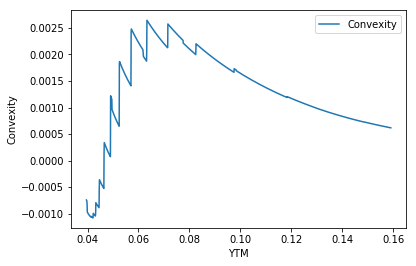

In [74]:
delt = 1
base= 1

print(y.shape)
print(priceC_sm.shape)

convexity = (priceC_sm[:(-2*delt)] + priceC_sm[(base+delt):] - 2*priceC_sm[(base):(-delt)])/\
(2*priceC_sm[(base):(-delt)]*np.square(y[(base+period):] - y[:-(base+period)])) 

plt.figure(figsize=(6,4))    
plt.plot(y[(base+period):],convexity,label='Convexity')
plt.xlabel('YTM')
plt.ylabel('Convexity')
plt.legend()
plt.show()

### Convexity - 3rd approach by smoothing the delta  --- Most reasonable results

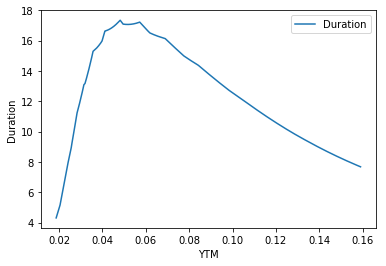

In [75]:
period = 100
priceC_sm = smooth_ave(priceC, period)
disc1 = 1
new_y = y[period - 1:]
delta = -((priceC_sm[disc1:] - priceC_sm[:-disc1]) / (priceC_sm[:-disc1])) / (new_y[disc1:] - new_y[:-disc1])
new_yy = new_y[disc1:]
plt.figure(figsize=(6,4))    
plt.plot(new_yy,delta,label='Duration')
plt.xlabel('YTM')
plt.ylabel('Duration')
plt.legend()
plt.show()

1691


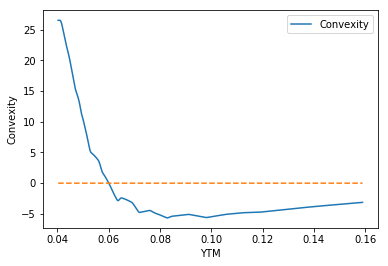

In [76]:
disc2 = 10
period2 = 200
delta_sm = smooth_ave(delta, period2)
gamma = (delta_sm[disc2:] - delta_sm[:-disc2]) / (new_yy[disc2 + period2 - 1:] - new_yy[:-disc2-period2+1])

print(len(gamma))

plt.figure(figsize=(6,4))    
plt.plot(new_yy[disc2 + period2 - 1:],gamma,label='Convexity')
plt.plot(new_yy[disc2 + period2 - 1:],np.zeros(len(new_yy[disc2 + period2 - 1:])),'--')
plt.xlabel('YTM')
plt.ylabel('Convexity')
plt.legend()
plt.show()

# Vasicek Model

## Monte Carlo on the short rates to option maturity. 

We used monte carlo simulation to generate N paths of short rate and get each discount factor for the two cash flows. The shape of the price is not same as binomial tree because we discount back the payoff which is a negative sloped line at option maturity. So we fit the price curve using the binomial tree instead of the monte carlo method. 

In [77]:
def vasicek(r0, K, theta, sigma, T, N_split, N_sample = 1000):
    dt = T/float(N_split)
    rate = np.ones(N_sample) * r0
    for i in range(N_split):
        dr = K*(theta-rate)*dt + sigma*np.random.normal(size = N_sample)
        rate = rate + dr
    return rate

def exact_zcb(theta, kappa, sigma, tau, r0=0.):
    B = (1 - np.exp(-kappa*tau)) / kappa
    A = np.exp((theta-(sigma**2)/(2*(kappa**2))) * (B-tau) - (sigma**2)/(4*kappa)*(B**2))
    return A * np.exp(-r0*B)

def calc_Callable_Price(r0, coupon, K, theta, sigma, kappa, call_price, N_split, N_sample, T, t, n = 2, face_value=100, call = True):
    time_step = 1.0 / n
    r1 = vasicek(r0, kappa, theta, sigma, t, N_split, N_sample)
    price_1 = np.zeros(N_sample)
    for time in np.arange(time_step, T - t + time_step, time_step):
        price_1 = price_1 + (coupon * face_value / n) * exact_zcb(theta, kappa, sigma, time, r1)
    price_1 = price_1 + face_value * exact_zcb(theta, kappa, sigma, T - t, r1)
    
    price_1_est = np.sum(price_1) / N_sample

    # compare with K
    if call:
        price_1_est = min(price_1_est, call_price)
    
    price_1_est = price_1_est * exact_zcb(theta, kappa, sigma, t, r0)
    # coupon before option exercise
    for time in np.arange(0, t + time_step, time_step):
        price_1_est = price_1_est + (coupon * face_value / n) * exact_zcb(theta, kappa, sigma, time, r0)
    
    return price_1_est

# T: Bond Maturity
def get_yield_from_shortrate(theta, kappa, sigma, time, r0, T):
    y = -np.log(exact_zcb(theta, kappa, sigma, time, r0))/(T)
    
    return y
    

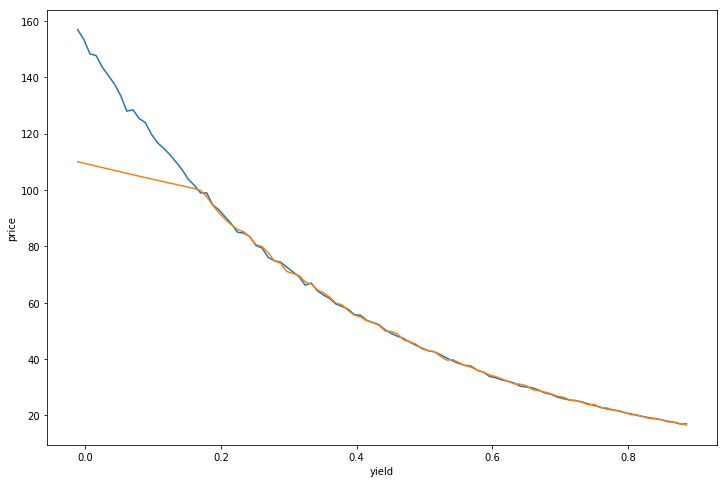

In [78]:
r0 = 0.02
K = 0.2
kappa = 0.02
theta = 0.01
sigma = 0.012

T = 10
t = 1
split = 10
coupon = 0
face_value = 100
call_price = 110

N = 1000
n = 2

interval = 0.001

price = []
initial_r = np.arange(0, 0.1, interval)
y = get_yield_from_shortrate(theta, kappa, sigma, T, initial_r, t);
for r0 in initial_r:
    price.append(calc_Callable_Price(r0, coupon, K, theta, sigma, kappa, call_price, N_split = 10, N_sample= 10000, T = 30, t = 5, call = False))
    
    
price_call = []
for r0 in initial_r:
    price_call.append(calc_Callable_Price(r0, coupon, K, theta, sigma, kappa, call_price, N_split = 10, N_sample= 10000, T = 30, t = 5))
    
    
price = np.array(price)
price_call = np.array(price_call)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(y, price)
ax.plot(y, price_call)
ax.set_xlabel('yield')
ax.set_ylabel('price')